In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import nltk
import nltk.corpus
import re
import matplotlib.pyplot as plt
import shap

from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer
from sklearn.model_selection import train_test_split
from sklearn import neural_network

from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelEncoder

tf.get_logger().setLevel('ERROR')

preprocess_url = "https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/4"

In [3]:
df = pd.read_csv("emails.csv")
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


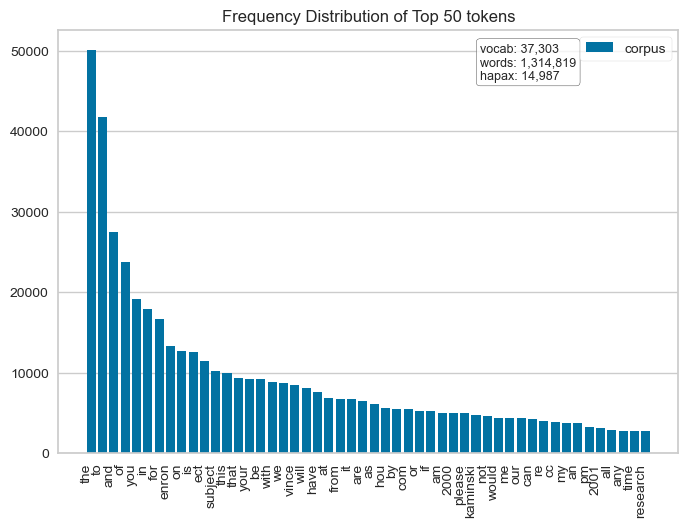

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [11]:
%matplotlib inline
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(df["text"])
features   = vectorizer.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

In [16]:
text = df["text"]
labels = df["spam"]

print(text.shape, labels.shape)

(5728,) (5728,)


In [17]:
# remove digits, @-mentions, links, stopwords

text = text.str.lower()
text = text.apply(lambda elem: re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", "", elem))
text = text.apply(lambda x : nltk.word_tokenize(x))
text = text.apply(lambda x : " ".join([word for word in x if word not in nltk.corpus.stopwords.words()]))

text.shape

In [ ]:
%matplotlib inline
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(df["text"])
features   = vectorizer.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(text), np.array(labels), train_size=100, shuffle=True)
for i in range(len(X_train)):
  X_train[i] = str(X_train[i])[2:-1]
  X_train[i] = tokenizer.tokenize(X_train[i])
  X_train[i] = tokenizer.convert_tokens_to_ids(X_train[i])

X_test = X_test[:50]
y_test = y_test[:50]

for i in range(len(X_test)):
  X_test[i] = str(X_test[i])[2:-1]
  X_test[i] = tokenizer.tokenize(X_test[i])
  X_test[i] = tokenizer.convert_tokens_to_ids(X_test[i])

In [ ]:
import torch

max_length = model.config.max_position_embeddings

X_train_padded = []
X_test_padded = []

for i in range(len(X_train)):
  X_train_padded.append(X_train[i] + [0] * (max_length - len(X_train[i])))
for i in range(len(X_test)):
  X_test_padded.append(X_test[i] + [0] * (max_length - len(X_test[i])))

X_train_padded = torch.from_numpy(np.array(X_train_padded))
X_test_padded = torch.from_numpy(np.array(X_test_padded))

In [ ]:
bert_train_output = model(X_train_padded)
print(bert_train_output)

In [ ]:
clf = neural_network.MLPClassifier()
clf.fit(X_train, le.transform(y_train))